In [17]:
import math
import numpy as np
from scipy import sparse
from karhunen_loeve import brownian_bridge1D, general_radial_kle
import h5py

# Finite difference solutions to 1D Helmholtz from input forcings which
# are stacked in an mxn matrix. Here m is the evenly-spaced
# grid discretization and n is the number of samples.
# Additional parameters are the grid spacing delta and the left
# and right Dirichlet boundary conditions left_dbc and right_dbc.
def solve_helmholtz1D(fs, w, delta, left_dbc = 0, right_dbc = 0):
    m, n = fs.shape
    us = np.zeros([m, n])
    K = sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(m-2, m-2))
    K = K/delta**2 - w**2*np.eye(m-2)
    for k in range(n):
        f_pert = np.copy(fs[1:m-1, k])
        f_pert[0] += left_dbc/delta**2
        f_pert[-1] += right_dbc/delta**2
        us[:, k] = np.concatenate(([left_dbc], np.linalg.solve(K, f_pert), [right_dbc]))
    return us

# number of samples
n = 1000

# mesh on [0, L]
L = 1

# Dirichlet (left and right endpoint) boundary conditions
left_dbc = -0.1
right_dbc = 0.1

# width of radial kernel
kernel_widths = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0]

# mesh sizes for forcing and solution
mesh_sizes = np.arange(100, 501, 50)
#mesh_sizes = np.arange(10, 101, 10)

## Poisson Brownian Bridge Forcing

In [13]:
mag = 1e1 # forcing magnitude for Poisson

# generate Brownian bridge forcing and solutions for Poisson equation
file = h5py.File("poisson_brownian_bridge1D_zerobc.hdf5", "a")
#file = h5py.File("poisson_brownian_bridge1D_dirbc.hdf5", "a")
w = 0 # wave number
for m in mesh_sizes:
    print(f"Mesh Size: {m}")
    mesh_grp = file.require_group(f"mesh{m}")
    xs = np.linspace(0, L, m)
    mesh_grp.attrs["mesh"] = xs
    delta = L/(m-1)
    
    fs = mag * brownian_bridge1D(xs, n, m, xmin=0, xmax=L)
    fs_dset = mesh_grp.create_dataset("forcings", data=fs.T)

    us = solve_helmholtz1D(fs, w, delta, left_dbc=left_dbc, right_dbc=right_dbc)
    us_dset = mesh_grp.create_dataset("solutions", data=us.T)

file.close()
del file

Mesh Size: 100
Mesh Size: 150
Mesh Size: 200
Mesh Size: 250
Mesh Size: 300
Mesh Size: 350



KeyboardInterrupt



## Poisson Gaussian KLE Forcing

In [18]:
mag = 1e1 # forcing magnitude for Poisson

# generate Gaussian KLE forcing and solutions for Poisson equation
#file = h5py.File("poisson_gaussianKLE1D_zerobc.hdf5", "a")
file = h5py.File("poisson_gaussianKLE1D_dirbc.hdf5", "a")
w = 0 # wave number
for m in mesh_sizes:
    print(f"Mesh Size: {m}")
    mesh_grp = file.require_group(f"mesh{m}")
    x_mesh = np.linspace(0, L, m)
    mesh_grp.attrs["mesh"] = (x_mesh,)
    delta = L/(m-1)
    
    for kernel_width in kernel_widths:
        print(f"Kernel Width: {kernel_width}")
        kernel_width_grp = mesh_grp.require_group(f"kernelwidth{kernel_width}")
        kernel = lambda x: np.exp(-(x**2)/kernel_width)
        fs = mag * general_radial_kle((x_mesh,), n, m, f=kernel)
        fs_dset = kernel_width_grp.create_dataset("forcings", data=fs.T)

        us = solve_helmholtz1D(fs, w, delta, left_dbc=left_dbc, right_dbc=right_dbc)
        us_dset = kernel_width_grp.create_dataset("solutions", data=us.T)

file.close()
del file

Mesh Size: 10
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 20
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 30
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 40
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
K

## Helmholtz Brownian Bridge Forcing

In [4]:
mag = 1e4 # forcing magnitude for Helmholtz

# generate Brownian bridge forcing and solutions for Helmholtz equation
w = 20 # wave number
#file = h5py.File(f"helmholtz_w{w}_brownian_bridge1D_zerobc.hdf5", "a")
file = h5py.File(f"helmholtz_w{w}_brownian_bridge1D_dirbc.hdf5", "a")
for m in mesh_sizes:
    print(f"Mesh Size: {m}")
    mesh_grp = file.require_group(f"mesh{m}")
    xs = np.linspace(0, L, m)
    mesh_grp.attrs["mesh"] = xs
    delta = L/(m-1)
    
    fs = brownian_bridge1D(xs, n, m, xmin=0, xmax=L)
    fs_dset = mesh_grp.create_dataset("forcings", data=fs.T)

    us = solve_helmholtz1D(fs, w, delta, left_dbc=left_dbc, right_dbc=right_dbc)
    us_dset = mesh_grp.create_dataset("solutions", data=us.T)

file.close()
del file

Mesh Size: 100
Mesh Size: 200
Mesh Size: 300
Mesh Size: 400
Mesh Size: 500
Mesh Size: 600
Mesh Size: 700
Mesh Size: 800
Mesh Size: 900
Mesh Size: 1000


## Helmholtz Gaussian KLE Forcing

In [18]:
mag = 1e2 # forcing magnitude for Helmholtz

# generate Gaussian KLE forcing and solutions for Helmholtz equation
#file = h5py.File("helmholtz_gaussianKLE1D_zerobc.hdf5", "a")
file = h5py.File("helmholtz_gaussianKLE1D_dirbc.hdf5", "a")
w = 20 # wave number
for m in mesh_sizes:
    print(f"Mesh Size: {m}")
    mesh_grp = file.require_group(f"mesh{m}")
    x_mesh = np.linspace(0, L, m)
    mesh_grp.attrs["mesh"] = (x_mesh,)
    delta = L/(m-1)
    
    for kernel_width in kernel_widths:
        print(f"Kernel Width: {kernel_width}")
        kernel_width_grp = mesh_grp.require_group(f"kernelwidth{kernel_width}")
        kernel = lambda x: np.exp(-(x**2)/kernel_width)
        fs = mag * general_radial_kle((x_mesh,), n, m, f=kernel)
        fs_dset = kernel_width_grp.create_dataset("forcings", data=fs.T)

        us = solve_helmholtz1D(fs, w, delta, left_dbc=left_dbc, right_dbc=right_dbc)
        us_dset = kernel_width_grp.create_dataset("solutions", data=us.T)

file.close()
del file

Mesh Size: 10
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 20
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 30
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
Kernel Width: 0.05
Kernel Width: 0.1
Kernel Width: 0.5
Kernel Width: 1.0
Mesh Size: 40
Kernel Width: 1e-06
Kernel Width: 5e-06
Kernel Width: 1e-05
Kernel Width: 5e-05
Kernel Width: 0.0001
Kernel Width: 0.0005
Kernel Width: 0.001
Kernel Width: 0.005
Kernel Width: 0.01
K

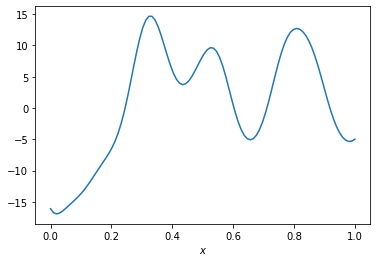

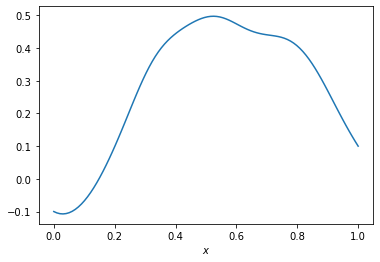

In [25]:
import matplotlib.pyplot as plt

m = 100
kernel_width = 0.01

data = h5py.File("poisson_gaussianKLE1D_dirbc_small.hdf5", "r")
mesh = data[f"mesh{m}"].attrs["mesh"][0]

fs = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["forcings"]
us = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["solutions"]

i = 50

plt.plot(mesh, fs[i, :])
plt.xlabel("$x$")
plt.show()

plt.plot(mesh, us[i, :])
plt.xlabel("$x$")
plt.show()